<a href="https://colab.research.google.com/github/cramosme/LLM-Phishing-Detection/blob/main/LLM_Phishing_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Clone git repo, comment out after running once
# !git clone https://github.com/cramosme/LLM-Phishing-Detection.git

# %cd LLM-Phishing-Detection

# !ls

In [2]:
import pandas as pd

# Load the CSVs
df_llm_phish = pd.read_csv(f"/content/LLM-Phishing-Detection/data/llm-generated/phishing-fixed.csv") # Have to use Fixed version and not original because original didnt quote text correctly so parsing was messed up
print(f"Loaded {len(df_llm_phish)} LLM Generated phishing emails")
display(df_llm_phish.info())

print("\n")

df_llm_legit = pd.read_csv(f"/content/LLM-Phishing-Detection/data/llm-generated/legit-fixed.csv") # Have to use Fixed version and not original because original didnt quote text correctly so parsing was messed up
print(f"Loaded {len(df_llm_legit)} LLM Generated legit emails")
display(df_llm_legit.info())

print("\n")

df_human_phish = pd.read_csv(f"/content/LLM-Phishing-Detection/data/human-generated/phishing.csv") # Issue only occured with the LLM ones, human generated we can just use the original dataset's files
print(f"Loaded {len(df_human_phish)} Human Generated phishing emails")
display(df_human_phish.info())

print("\n")

df_human_legit = pd.read_csv(f"/content/LLM-Phishing-Detection/data/human-generated/legit.csv")
print(f"Loaded {len(df_human_legit)} Human Generated legit emails")
display(df_human_legit.info())

Loaded 1000 LLM Generated phishing emails
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1000 non-null   object
 1   label   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


None



Loaded 1000 LLM Generated legit emails
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1000 non-null   object
 1   label   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


None



Loaded 1000 Human Generated phishing emails
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    1000 non-null   object
 1   receiver  978 non-null    object
 2   date      1000 non-null   object
 3   subject   998 non-null    object
 4   body      1000 non-null   object
 5   urls      1000 non-null   int64 
 6   label     1000 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 54.8+ KB


None



Loaded 1000 Human Generated legit emails
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    1000 non-null   object
 1   receiver  984 non-null    object
 2   date      1000 non-null   object
 3   subject   1000 non-null   object
 4   body      1000 non-null   object
 5   urls      1000 non-null   object
 6   label     1000 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 54.8+ KB


None

## Printing out the value count to check that all 1000 values are the same. Phish is 1. Legit is 0.

In [3]:
df_llm_phish['label'].value_counts()

,count
label,
1,1000


In [4]:
df_llm_legit['label'].value_counts()

,count
label,
0,1000


In [5]:
df_human_phish['label'].value_counts()

,count
label,
1,1000


In [6]:
df_human_legit['label'].value_counts()

,count
label,
0,1000


In [8]:
# Extract only the body text from the Human CSVs for consistency. LLM CSVs only contain a text box, with no metadata like the Human ones.
# If we use the metadata in training the model might spot patterns and classify anything with metadata as Human.
# To avoid that we will only be looking at the body of the email.

# Add text column to human dataframes, just to keep columns consistent with LLM
df_human_phish['text'] = df_human_phish['body']
df_human_legit['text'] = df_human_legit['body']

# Make sure both columns got added
df_human_legit.info()
df_human_phish.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    1000 non-null   object
 1   receiver  984 non-null    object
 2   date      1000 non-null   object
 3   subject   1000 non-null   object
 4   body      1000 non-null   object
 5   urls      1000 non-null   object
 6   label     1000 non-null   int64 
 7   text      1000 non-null   object
dtypes: int64(1), object(7)
memory usage: 62.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    1000 non-null   object
 1   receiver  978 non-null    object
 2   date      1000 non-null   object
 3   subject   998 non-null    object
 4   body      1000 non-null   object
 5   urls      1000 non-null   int64 
 6   label     1000 non-null   int64 
 7   text      10

In [9]:
# Will be conducting two training experiments. Training the ML model on only the phishing emails and training on all emails.
# We want to see if the model's performance is impacted.

# Add source labels to each dataframe
df_human_phish['source'] = 0    # Human
df_llm_phish['source'] = 1      # LLM
df_human_legit['source'] = 0    # Human
df_llm_legit['source'] = 1      # LLM

# Create phishing-only dataset
df_phishing_only = pd.concat([
    df_llm_phish[['text','source']], df_human_phish[['text','source']]
], ignore_index=True)

# Create all-emails dataset
df_all_emails = pd.concat([
    df_llm_phish[['text','source']], df_human_phish[['text','source']],
    df_llm_legit[['text','source']], df_human_legit[['text','source']]
], ignore_index=True)

# Verify both datasets
print("=== Phishing-Only Dataset ===")
print(f"Total samples: {len(df_phishing_only)}")
print(df_phishing_only['source'].value_counts())

print("\n=== All-Emails Dataset ===")
print(f"Total samples: {len(df_all_emails)}")
print(df_all_emails['source'].value_counts())


=== Phishing-Only Dataset ===
Total samples: 2000
source
1    1000
0    1000
Name: count, dtype: int64

=== All-Emails Dataset ===
Total samples: 4000
source
1    2000
0    2000
Name: count, dtype: int64


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, classification_report, recall_score, precision_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Random State
rState = 42
test_size = 0.3 # 70% train, 30% test

# Using the 3000 most important words. Stop words english removes common words ("the", "and"...)
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')

In [15]:
# Phishing Only (Human vs LLM Phishing emails)

# Separating features and labels
X_phish = df_phishing_only['text']
y_phish = df_phishing_only['source']

# Converting text to numbers using TFIDF
X_phish_conversion = vectorizer.fit_transform(X_phish)
print(f"Created {X_phish_conversion.shape[1]} features from the text (top {X_phish_conversion.shape[1]} words)")

X_train_phish, X_test_phish, y_train_phish, y_test_phish = train_test_split(X_phish_conversion, y_phish, test_size=test_size, random_state=rState, stratify=y_phish) # Stratify ensures that its even 700/700 split

print(f"\nTraining samples: {X_train_phish.shape[0]}")
print(f"Testing samples: {X_test_phish.shape[0]}")
print(f"\nClass distribution in training:")
print(y_train_phish.value_counts())

Created 3000 features from the text (top 3000 words)

Training samples: 1400
Testing samples: 600

Class distribution in training:
source
0    700
1    700
Name: count, dtype: int64


# Logistic Regression

In [16]:
# Train logistic regression model

# Initialize model
log_reg = LogisticRegression(max_iter=1000, random_state=rState, solver='liblinear')

# Fit the model
log_reg.fit(X_train_phish, y_train_phish)

y_pred_phish = log_reg.predict(X_test_phish)
y_prob_phish = log_reg.predict_proba(X_test_phish)[:, 1] # Probability of LLM (class 1)



Accuracy: 0.9967
Precision: 1.0000
Recall: 0.9933
F1 Score: 0.9967


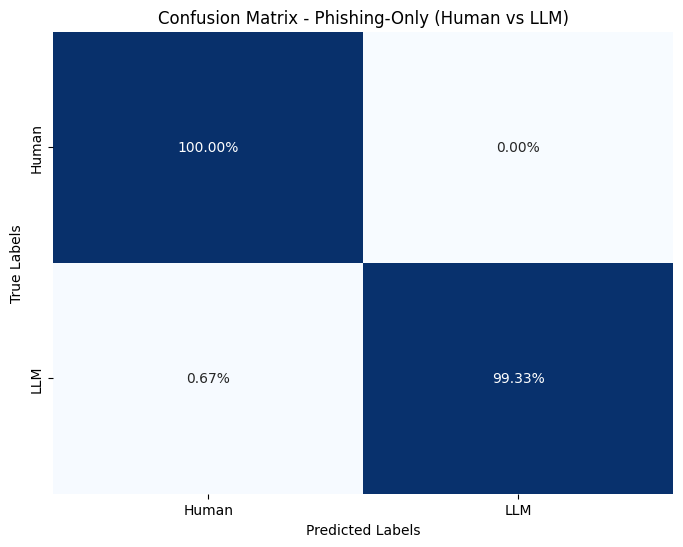


------------------------------------------------------------
               Classification Report
              precision    recall  f1-score   support

       Human       0.99      1.00      1.00       300
         LLM       1.00      0.99      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [33]:
# Calculate metrics
accuracy = accuracy_score(y_test_phish, y_pred_phish)
precision = precision_score(y_test_phish, y_pred_phish)
recall = recall_score(y_test_phish, y_pred_phish)
f1 = f1_score(y_test_phish, y_pred_phish)

# Print metrics
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test_phish, y_pred_phish, normalize="true")
labels = ["Human", "LLM"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Phishing-Only (Human vs LLM)')
plt.show()

# Classification Report
print("\n" + "-" * 60)
print(' ' * 15 + "Classification Report")
print(classification_report(y_test_phish, y_pred_phish, target_names=labels))

In [27]:
# Create a dataframe with test results
test_results = pd.DataFrame({
    'text': df_phishing_only.loc[y_test_phish.index, 'text'], # the email text
    'true_label': y_test_phish.values, # What the actual label is
    'predicted_label': y_pred_phish, # What the model predicted
    'probability_LLM': y_prob_phish # How confident the model was
})

# Find misclassified emails, filters to only the rows where true label doesnt match predicted
misclassified = test_results[test_results['true_label'] != test_results['predicted_label']]

print(f"\nTotal misclassified: {len(misclassified)}")

# Show each misclassified email
for index, row in misclassified.iterrows():
    true_class = "LLM" if row['true_label'] == 1 else "Human"
    pred_class = "LLM" if row['predicted_label'] == 1 else "Human"

    print(f"\nMisclassified Email #{index}")
    print(f"True Label: {true_class}")
    print(f"Predicted: {pred_class}")
    print(f"Confidence (LLM probability): {row['probability_LLM']:.4f}")
    print(f"\nEmail Text (first 500 characters):")
    print("-" * 60)
    print(row['text'][:500])


Total misclassified: 2

Misclassified Email #645
True Label: LLM
Predicted: Human
Confidence (LLM probability): 0.4815

Email Text (first 500 characters):
------------------------------------------------------------
Hey Madison! I found a book that I think you'll absolutely love. It's been getting rave reviews. Click here to discover your new favorite book: https://www.apple.com/it/. Happy reading!

Misclassified Email #804
True Label: LLM
Predicted: Human
Confidence (LLM probability): 0.4686

Email Text (first 500 characters):
------------------------------------------------------------
We're inviting you to become a secret shopper and earn extra cash. Visit our website and sign up to start receiving assignments. Your attention to detail and honest feedback will be greatly appreciated!


# Random Forest

In [34]:
# Initialize the random forest
rf = RandomForestClassifier(n_estimators=100, random_state=rState, n_jobs=1)

# Fit the model
rf.fit(X_train_phish, y_train_phish)

# Make pred
rf_y_pred = rf.predict(X_test_phish)
rf_y_prob = rf.predict_proba(X_test_phish)[:, 1]


Accuracy: 0.9950
Precision: 0.9934
Recall: 0.9967
F1 Score: 0.9950


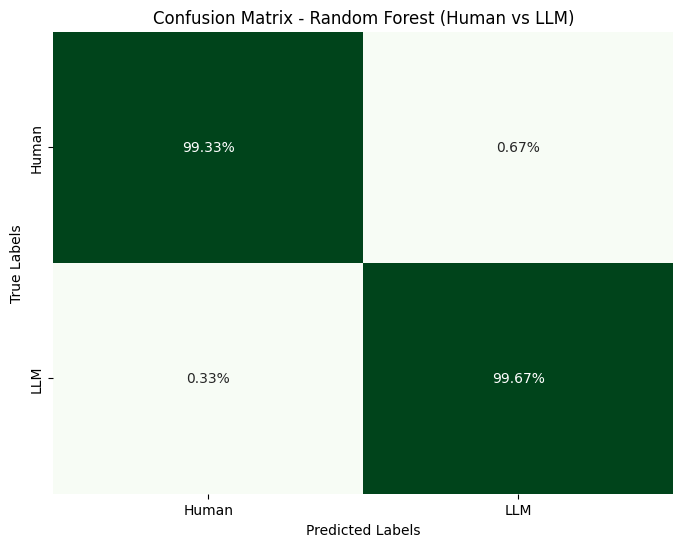


------------------------------------------------------------
               Classification Report
              precision    recall  f1-score   support

       Human       1.00      0.99      0.99       300
         LLM       0.99      1.00      1.00       300

    accuracy                           0.99       600
   macro avg       1.00      0.99      0.99       600
weighted avg       1.00      0.99      0.99       600

   MODEL COMPARISON
Metric          Winner
---------------------------------------------
Accuracy        Logistic Regression
Precision       Logistic Regression
Recall          Random Forest
F1 Score        Logistic Regression


In [51]:
# Calculate metrics
accuracy_rf = accuracy_score(y_test_phish, rf_y_pred)
precision_rf = precision_score(y_test_phish, rf_y_pred)
recall_rf = recall_score(y_test_phish, rf_y_pred)
f1_rf = f1_score(y_test_phish, rf_y_pred)

# Print metrics
print(f"\nAccuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")

# Confusion Matrix
cm_rf = confusion_matrix(y_test_phish, rf_y_pred, normalize="true")

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='.2%', cmap='Greens', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Random Forest (Human vs LLM)')
plt.show()

# Classification Report
print("\n" + "-" * 60)
print(' ' * 15 + "Classification Report")
print(classification_report(y_test_phish, rf_y_pred, target_names=labels))

def winner(lr_score, rf_score):
    if lr_score > rf_score:
        return "Logistic Regression"
    elif rf_score > lr_score:
        return "Random Forest"

# Compare with Logistic Regression
print("   MODEL COMPARISON")
print(f"{'Metric':<15} {'Winner'}")
print("-" * 45)
print(f"{'Accuracy':<15} {winner(accuracy, accuracy_rf)}")
print(f"{'Precision':<15} {winner(precision, precision_rf)}")
print(f"{'Recall':<15} {winner(recall, recall_rf)}")
print(f"{'F1 Score':<15} {winner(f1, f1_rf)}")

- Logistic Regression: Missed 2 LLM emails, misclassified as Human (2 false negatives, 0 false positives)
- Random Forest: Missed 1 LLM email, but also misclassified 2 Human emails as LLM (1 false negative, 2 false positives)

- Random Forest has better recall
- Logistic Regression has better precision

# Testing with all emails, legitimitate and phishing. 4000 samples

In [52]:
# All emails (Human vs LLM emails)

# Separating features and labels
X_all = df_all_emails['text']
y_all = df_all_emails['source']

# Converting text to numbers using TFIDF
X_all_conversion = vectorizer.fit_transform(X_all)
print(f"Created {X_all_conversion.shape[1]} features from the text (top {X_all_conversion.shape[1]} words)")

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all_conversion, y_all, test_size=test_size, random_state=rState, stratify=y_all) # Stratify ensures that its even 700/700 split

print(f"\nTraining samples: {X_train_all.shape[0]}")
print(f"Testing samples: {X_test_all.shape[0]}")
print(f"\nClass distribution in training:")
print(y_train_all.value_counts())

Created 3000 features from the text (top 3000 words)

Training samples: 2800
Testing samples: 1200

Class distribution in training:
source
0    1400
1    1400
Name: count, dtype: int64


# Logistic Regression With All Emails

In [59]:
# Train logistic regression model

# Initialize model
log_reg = LogisticRegression(max_iter=1000, random_state=rState, solver='liblinear')

# Fit the model
log_reg.fit(X_train_all, y_train_all)

y_pred_all = log_reg.predict(X_test_all)
y_prob_all = log_reg.predict_proba(X_test_all)[:, 1] # Probability of LLM (class 1)



Accuracy: 0.9992
Precision: 1.0000
Recall: 0.9983
F1 Score: 0.9992


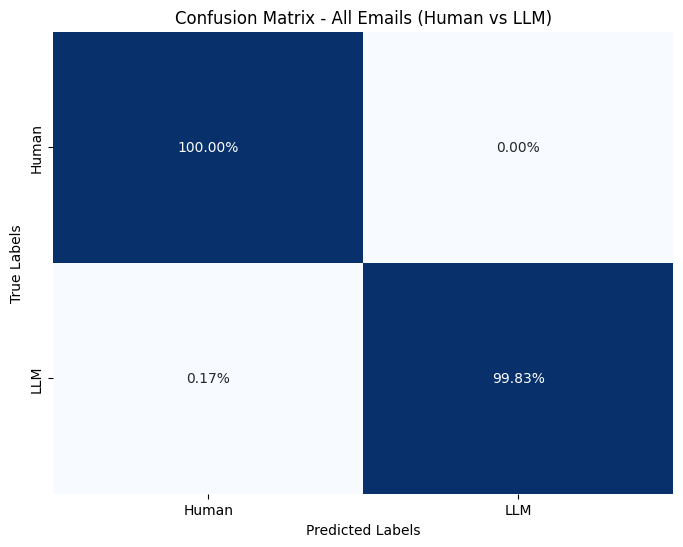


------------------------------------------------------------
               Classification Report
              precision    recall  f1-score   support

       Human       1.00      1.00      1.00       600
         LLM       1.00      1.00      1.00       600

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



In [55]:
# Calculate metrics
accuracy = accuracy_score(y_test_all, y_pred_all)
precision = precision_score(y_test_all, y_pred_all)
recall = recall_score(y_test_all, y_pred_all)
f1 = f1_score(y_test_all, y_pred_all)

# Print metrics
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test_all, y_pred_all, normalize="true")
labels = ["Human", "LLM"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - All Emails (Human vs LLM)')
plt.show()

# Classification Report
print("\n" + "-" * 60)
print(' ' * 15 + "Classification Report")
print(classification_report(y_test_all, y_pred_all, target_names=labels))

In [56]:
# Create a dataframe with test results
test_results = pd.DataFrame({
    'text': df_all_emails.loc[y_test_all.index, 'text'], # the email text
    'true_label': y_test_all.values, # What the actual label is
    'predicted_label': y_pred_all, # What the model predicted
    'probability_LLM': y_prob_all # How confident the model was
})

# Find misclassified emails, filters to only the rows where true label != predicted
misclassified = test_results[test_results['true_label'] != test_results['predicted_label']]

print(f"\nTotal misclassified: {len(misclassified)}")

# Show each misclassified email
for index, row in misclassified.iterrows():
    true_class = "LLM" if row['true_label'] == 1 else "Human"
    pred_class = "LLM" if row['predicted_label'] == 1 else "Human"

    print(f"\nMisclassified Email #{index}")
    print(f"True Label: {true_class}")
    print(f"Predicted: {pred_class}")
    print(f"Confidence (LLM probability): {row['probability_LLM']:.4f}")
    print(f"\nEmail Text (first 500 characters):")
    print("-" * 60)
    print(row['text'][:500])


Total misclassified: 1

Misclassified Email #804
True Label: LLM
Predicted: Human
Confidence (LLM probability): 0.3720

Email Text (first 500 characters):
------------------------------------------------------------
We're inviting you to become a secret shopper and earn extra cash. Visit our website and sign up to start receiving assignments. Your attention to detail and honest feedback will be greatly appreciated!


# Random Forest for all emails

In [57]:
# Initialize the random forest
rf = RandomForestClassifier(n_estimators=100, random_state=rState, n_jobs=1)

# Fit the model
rf.fit(X_train_all, y_train_all)

# Make pred
rf_y_pred = rf.predict(X_test_all)
rf_y_prob = rf.predict_proba(X_test_all)[:, 1]


Accuracy: 0.9975
Precision: 0.9967
Recall: 0.9983
F1 Score: 0.9975


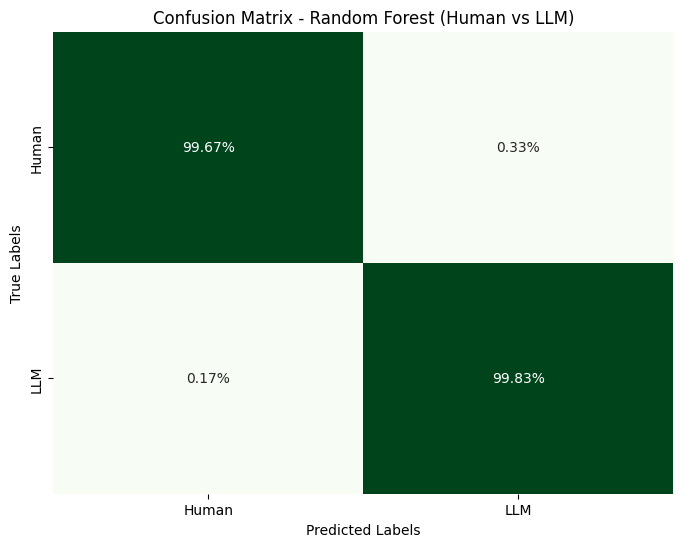


------------------------------------------------------------
               Classification Report
              precision    recall  f1-score   support

       Human       1.00      1.00      1.00       600
         LLM       1.00      1.00      1.00       600

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200

   MODEL COMPARISON
Metric          Winner
---------------------------------------------
Accuracy        Logistic Regression
Precision       Logistic Regression
Recall          Tie
F1 Score        Logistic Regression


In [60]:
# Calculate metrics
accuracy_rf = accuracy_score(y_test_all, rf_y_pred)
precision_rf = precision_score(y_test_all, rf_y_pred)
recall_rf = recall_score(y_test_all, rf_y_pred)
f1_rf = f1_score(y_test_all, rf_y_pred)

# Print metrics
print(f"\nAccuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")

# Confusion Matrix
cm_rf = confusion_matrix(y_test_all, rf_y_pred, normalize="true")

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='.2%', cmap='Greens', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Random Forest (Human vs LLM)')
plt.show()

# Classification Report
print("\n" + "-" * 60)
print(' ' * 15 + "Classification Report")
print(classification_report(y_test_all, rf_y_pred, target_names=labels))

def winner(lr_score, rf_score):
    if lr_score > rf_score:
        return "Logistic Regression"
    elif rf_score > lr_score:
        return "Random Forest"
    else:
      return "Tie"

# Compare with Logistic Regression
print("   MODEL COMPARISON")
print(f"{'Metric':<15} {'Winner'}")
print("-" * 45)
print(f"{'Accuracy':<15} {winner(accuracy, accuracy_rf)}")
print(f"{'Precision':<15} {winner(precision, precision_rf)}")
print(f"{'Recall':<15} {winner(recall, recall_rf)}")
print(f"{'F1 Score':<15} {winner(f1, f1_rf)}")